<h1><center>Credit Card Approval Classification</center></h1>

<h1><center>- Classification of eligible/non-eligible credit card applicants -</center></h1>

**Objective of notebook:** This project is about analyzing and modeling data of credit card applicants in the financial sector for predicting their suitability for receiving a credit card.
The data that has been used for the EDA (Exploratory Data Analysis) and ML modeling, was downloaded from the **Kaggle dataset "Credit Card Approval Prediction"**.


**KEY WORDS:**
- One hot encoding
- Exploratory Data Analysis (EDA)
- Data synthesizing (SMOTE)
- Binary Classification 
- Model Evaluation

First, the necessary python packages and Machine Learning frameworks are imported into the notebook. Furthermore, the two datasets "**application_record**" and "**credit_record**" are loaded into the notebook.

- **application_record.csv:** Contains all the characterizing data of the applicant
- **credit_record.csv:** Contains applicant IDs and the corresponding status of their payments

In [78]:
import numpy as np

import os
import pandas as pd
import scipy as sc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype
from scipy import stats as st
from scipy.stats import norm
from imblearn.over_sampling import SMOTE

from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, roc_auc_score

from functools import reduce



In [79]:
# Load the data with the applicant data:
app_record = pd.read_csv("application_record.csv")
# Load the data with the ID-wise payment records:
credit_record = pd.read_csv("credit_record.csv")
'''
print("App record data:\n", app_record.head(5), "\n\n")
print("--------------------------------------------------------------------")
print("Credit record data:\n", credit_record.head(5))
'''

'\nprint("App record data:\n", app_record.head(5), "\n\n")\nprint("--------------------------------------------------------------------")\nprint("Credit record data:\n", credit_record.head(5))\n'

After loading the data, some data cleaning has to be done. Both datasets are checked, whether they contain any missing data values.
The missing values are then filled in a way that makes sense in this specific case:

In [80]:
# Method to check for missing values in the dataset:
def check_missings(data):
    n_missing_vals = pd.isnull(data).sum()
    
    return n_missing_vals

missing_vals_ar = check_missings(app_record)
missing_vals_cr = check_missings(credit_record)

print("Missing values of app_cord:\n ", missing_vals_ar, "\n")
print("Missing values of credit_cord:\n ", missing_vals_cr, "\n")

# Fill missing values of the occupation type column with 'Unknown':
app_record['OCCUPATION_TYPE'] = app_record['OCCUPATION_TYPE'].fillna(value="Unknown")

# Show the result of filling the missing values:
print("Filled occupation types:\n", app_record['OCCUPATION_TYPE'].head(10))

Missing values of app_cord:
  ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64 

Missing values of credit_cord:
  ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64 

Filled occupation types:
 0           Unknown
1           Unknown
2    Security staff
3       Sales staff
4       Sales staff
5       Sales staff
6       Sales staff
7           Unknown
8           Unknown
9           Unknown
Name: OCCUPATION_TYPE, dtype: object


Next, the classes of "good" and "bad" applicants have to be defined. For doing that, we look at the "STATUS" column of the credit records, which shows the data of the past payment bahaviour of the applicants (IDs). Derived from that, we can create a dictionary of how we define "good" payment behaviour, "bad" payment behaviour and so on.

The applicants' payment status can then belong to the following data:
<br>

                                             'C' : 'Good_Behaviour'
                                             'X' : 'No_Loan'
                                             '0' : 'Good_Behaviour'
                                             '1' : 'Bad_Behaviour'
                                             '2' : 'Bad_Behaviour'
                                             '3' : 'Very_Bad_Behaviour'
                                             '4' : 'Very_Bad_Behaviour'    
                                             '5' : 'Very_Bad_Behaviour'

Since we want each applicant ID to belong to a binary class {0,1} for our classification model, certain thresholds are created which we use to assign the applicant to either **0 (bad applicant) or 1 (good applicant)**:

- If at least **20%** of the applicants' payments were of the _"Bad_Behaviour"_ category, mark it as **0**
- If at least **80%** of the applicants' payments is _"No_Loan"_ then mark it as **0**. This is because someone that is **not** asking for credits should not be considered a viable candidate as she/he would only generate work with and no profit for the bank (paperwork, etc).<br>
- If the person had **at least 1** payment marked with _"Very_Bad_Behaviour"_, then mark her/him as **0** as well. This is because _"Very_Bad_Behaviour"_ is belongs to payments that are still not paid or have at least 90 days overdue which shows a clear risk on giving these applicants a credit.
- Everything else will be declared as _"Good_Behaviour"_ and belongs to the class **1**.


In [81]:
# Create a method for converting the payment categories {C,X,0,1,2,3,4,5} into a "Good vs Bad" dataset.
# For each applicant ID, the payments are compared with defined thresholds and assigned to one of the classes {0,1}.
def credit_transform (data):
    
    data['STATUS_TRANSF'] = data['STATUS']
    
    data = data.replace({'STATUS_TRANSF' :
                                            {'C' : 'Good_Behaviour',          # applicant already paid off this month
                                             'X' : 'No_Loan',                 # no loan this month
                                             '0' : 'Good_Behaviour',          # 1-29 days past due
                                             '1' : 'Bad_Behaviour',           # 30-59 days past due
                                             '2' : 'Bad_Behaviour',           # 60-89 days past due
                                             '3' : 'Bad_Behaviour',           # 90-119 days past due
                                             '4' : 'Very_Bad_Behaviour',           # 120-149 days past due
                                             '5' : 'Very_Bad_Behaviour'}})    # overdue or bad depts, write-offs for more than 150 days

    # Define a variable which summarizes the data for euach ID:
    counts_per_id = data.value_counts(subset=['ID', 'STATUS_TRANSF']).unstack(fill_value=0)
    
    # Get the total payments of an applicant:
    counts_per_id['Total_Payments'] = counts_per_id['Bad_Behaviour']+counts_per_id['Good_Behaviour']+counts_per_id['Very_Bad_Behaviour']+counts_per_id['No_Loan']
    
    # If at least 20% of an ID's payments show bad behaviour --> assign to class 0!
    counts_per_id.loc[((counts_per_id['Bad_Behaviour'])/counts_per_id['Total_Payments'] >= .20), 'Status'] = 0
    # If at least 80% of an ID's payments show no loan --> assign to class 0!
    counts_per_id.loc[((counts_per_id['No_Loan'])/counts_per_id['Total_Payments'] >= .80), 'Status'] = 0
    # If at least one of an ID's payments show very bad behaviour --> assign to class 0!
    counts_per_id.loc[(counts_per_id['Very_Bad_Behaviour'] > 0), 'Status'] = 0
    # Assign the remaining ID's to the class 1!
    counts_per_id['Status'] = counts_per_id['Status'].fillna(value=1)
    counts_per_id['Status'] = counts_per_id['Status'].astype(int)
    status_count = pd.DataFrame(counts_per_id['Status'].value_counts())
    
    status_count.loc[[1,0],'Decision']='Good'
    status_count.loc[[0,0],'Decision']='Bad'
    print("Total data (IDs)= ", status_count['Status'].sum(axis=0), "\n") 
    print("Count of ID's per class:\n", status_count)      
    return counts_per_id

# Define the dataset that shows the payments summary of each ID as well as the class it has been assigned to:
credit_gvb = credit_transform(credit_record)

print("Credit 'Good vs Bad' dataset:\n")
credit_gvb.head(10)

Total data (IDs)=  45985 

Count of ID's per class:
    Status Decision
1   39376     Good
0    6609      Bad
Credit 'Good vs Bad' dataset:



STATUS_TRANSF,Bad_Behaviour,Good_Behaviour,No_Loan,Very_Bad_Behaviour,Total_Payments,Status
ID,,,,,,
5001711,0,3,1,0,4,1
5001712,0,19,0,0,19,1
5001713,0,0,22,0,22,0
5001714,0,0,15,0,15,0
5001715,0,0,60,0,60,0
5001717,0,22,0,0,22,1
5001718,2,27,10,0,39,1
5001719,0,43,0,0,43,1
5001720,7,29,0,0,36,1


In [82]:
# Group data of the original credit records by IDs and check if it matches the "credit_gvb" dataset:
credit_record = credit_record.groupby('ID').agg({'MONTHS_BALANCE' : 'max', 'STATUS' : 'first'})
assert credit_record.shape[0] == credit_gvb.shape[0]

print("Credit record data grouped by IDs:\n")
credit_record.head(20)

Credit record data grouped by IDs:



,MONTHS_BALANCE,STATUS
ID,,
5001711,0,X
5001712,0,C
5001713,0,X
5001714,0,X
5001715,0,X
5001717,0,C
5001718,0,C
5001719,0,C
5001720,0,1


After checking for missing values and defining the classes for "good" and "bad" applicant IDs, we have to check for duplicant entries.

A method is created, that will **check**, whether there are **duplicated IDs** in the app record data, which also appear in the credit record data. The found duplicated IDs are dropped and the credit record data is merged with the app record data afterwards.

In [83]:
# Create a method for duplicate checking and dropping:
def dup_check (data1,data2):
    
    """
    data1 = application record dataset
    data2 = credit record dataset (with "good vs bad" identification)
    
    """
    # Check for duplicates in the app records:
    duplicate_id = data1['ID'].value_counts()
    duplicate_id = pd.DataFrame(duplicate_id)
    
    # Drop detected duplicates
    duplicate_id.drop(duplicate_id.loc[duplicate_id['ID']==1].index, inplace=True)
    duplicate_id.reset_index(inplace=True)
    duplicate_id = duplicate_id.rename(columns={'ID':'Aprnz', 'index' : 'ID'})
    
    # Merge the datasets together:
    data2 = data2.merge(duplicate_id, on="ID")  
    
    return data2

Next, a method is created for splitting the data into a **dataset for training the model** and one significantly larger **dataset without the target labels (0,1)**.

The much larger data set comes from the fact that the **training dataset is compressed** since we put all the payment entries into one single row **for each ID**.

When training ML models, we **usually train-test-split with a ratio like 80/20** (depending on the type of application). That means we will just use a small fraction of the data without labels and treat this subset as **test data** which represents unseen data entries for new credit card applicants.
This test data can then be used to make predictions with the (not yet) trained classification model.

The remaining **training data with ~ 36,500** entries will later be split up into a subset for the actual training and a cross-validation subset for evaluating the classification model.

In [84]:
# Method for train-test splitting:
def tt_split (data1,data2):

        """
        data1 = application record dataset
        data2 = credit record dataset (with "good vs bad" identification)
        
        """
        data1_beforedrop = data1.shape[0]
        data1 = data1.drop_duplicates(subset ="ID", keep = False)
        print("Number of duplicant rows dropped = ", data1_beforedrop, "-", data1.shape[0], "=", data1_beforedrop-data1.shape[0])
        train_data = data1.merge(data2, on="ID")
        test_data_raw1 = pd.merge(data1, train_data, how='outer', indicator=True)
        test_data = test_data_raw1[test_data_raw1._merge != 'both']
        test_data = test_data.drop(['Bad_Behaviour', 'Good_Behaviour', 'Status', '_merge', 'No_Loan', 'Very_Bad_Behaviour', 'Total_Payments'], axis=1)

        print("Shape of the training data = ", train_data.shape)
        print("Shape of the test data = ", test_data.shape)
        print("The total amount of data entries = ", train_data.shape[0]+test_data.shape[0], ".", "Applicaton record has", data1.shape[0], "rows.")

        return train_data, test_data

In [85]:
dup_check(app_record,credit_gvb)

,ID,Bad_Behaviour,Good_Behaviour,No_Loan,Very_Bad_Behaviour,Total_Payments,Status,Aprnz


In [86]:
# Perform the train-test-split on the dataframe:
train_data, test_data = tt_split(app_record, credit_gvb)

Number of duplicant rows dropped =  438557 - 438463 = 94
Shape of the training data =  (36457, 24)
Shape of the test data =  (402006, 18)
The total amount of data entries =  438463 . Applicaton record has 438463 rows.


In [87]:
# Show the content of the first entries of the cleaned and splittet training data:
#train_data.head(10)

Next, a method for **resetting the index** of the training dataframe is created. Resetting the index has to be done, since the process of duplicate dropping and data merging resulted in some gaps in the index column.

In [88]:
# Create a method for resetting the index column and getting a proper order:
def index_reset (data):
    
    data = data.reset_index()
    data.drop(['index'], inplace=True, axis=1)
    return data

# Reset the index column for having proper ordered index:
train_data = index_reset(train_data)
test_data = index_reset(test_data)

At this point, some **Exploratory Data Analysis** has to be done in orer to gain insights about which features seem to be helpful when selecting them for training the classifier.

First we will look at the features with **numerical data in order to look for outliers**. For that, a scatterplot for each continuous feature is created:

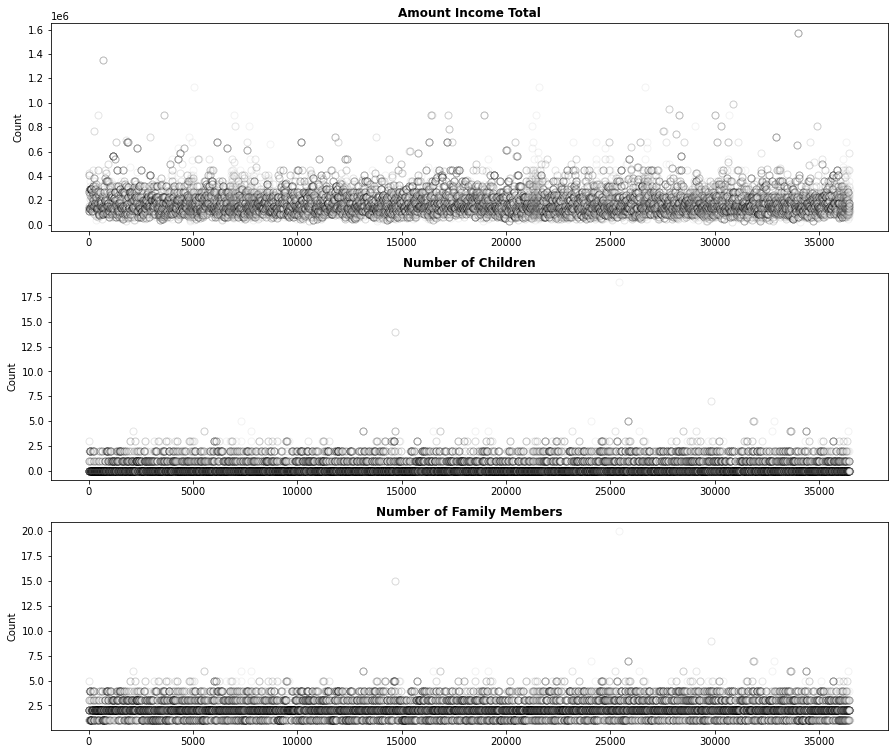

In [89]:
# Define the figure
fig, ax = plt.subplots(3, figsize=(15, 13))

# Plot the amount of total income:
ax[0].plot(train_data['AMT_INCOME_TOTAL'] , "", data=train_data, linestyle='', marker='o', markersize=7, alpha=0.05, color="white", mec="black")
ax[0].set_title("Amount Income Total", fontweight='bold')
ax[0].set_ylabel("Count")
ax[0]

# Plot the number of children:
ax[1].plot(train_data['CNT_CHILDREN'] , "", data=train_data, linestyle='', marker='o', markersize=7, alpha=0.05, color="white", mec="black")
ax[1].set_title("Number of Children", fontweight='bold')
ax[1].set_ylabel("Count")

# Plot the number of family members:
ax[2].plot(train_data['CNT_FAM_MEMBERS'] , "", data=train_data, linestyle='', marker='o', markersize=7, alpha=0.05, color="white", mec="black")
ax[2].set_title("Number of Family Members", fontweight='bold')
ax[2].set_ylabel("Count")

plt.show()

By looking at the data, we cannot conclude that there are data points holdings values that seem unrealistic to us.

Since we still have a large percentage of 'Unknown' data in the Occupation type column, we will collect some statistics in order to see, if the occupation type is a potential feature or if we can drop the column without loosing important information:

In [90]:
def remove_outliers(data, column, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """
    data_old = data.shape[0]
    data = index_reset(data)
    data = data.loc[(data[column] > lower) & (data[column] < upper)]
    return data

In [91]:
# Create a method for grouping categorical and numerical data by their statistics:
def desc_stats_grouper (data, column1, column2):
    """
    data =  train dataset
    column1 =  categorical feature
    column2 = numerical feature
    """
    
    occup_income_train = data[[column1, column2]]
    occup_income_mean = occup_income_train.groupby(column1).mean()
    occup_income_mean = occup_income_mean.rename(columns={column2:'Mean'})
    occup_income_median = occup_income_train.groupby(column1).median()
    occup_income_median = occup_income_median.rename(columns={column2:'Median'})
    occup_income_min = occup_income_train.groupby(column1).min()
    occup_income_min = occup_income_min.rename(columns={column2:'Min'})
    occup_income_max = occup_income_train.groupby(column1).max()
    occup_income_max = occup_income_max.rename(columns={column2:'Max'})
    occup_income_std = occup_income_train.groupby(column1).std()
    occup_income_std = occup_income_std.rename(columns={column2:'Std'})
    occup_income = [occup_income_mean, occup_income_median, occup_income_min, occup_income_max, occup_income_std]
    occup_income = pd.concat(occup_income, axis=1)
    return occup_income
    

In [92]:
# Group occupation income:
occup_income = desc_stats_grouper(train_data, 'OCCUPATION_TYPE', 'AMT_INCOME_TOTAL')
occup_income

,Mean,Median,Min,Max,Std
OCCUPATION_TYPE,,,,,
Accountants,202463.865834,180000.0,45000.0,661500.0,104946.611731
Cleaning staff,149141.107078,135000.0,31500.0,450000.0,67772.783240
Cooking staff,146517.251908,135000.0,40500.0,495000.0,71223.962838
Core staff,190172.786967,166500.0,36000.0,990000.0,100864.352138
Drivers,209797.240412,202500.0,58500.0,900000.0,88854.415542
HR staff,193764.705882,157500.0,112500.0,675000.0,115849.465858
High skill tech staff,196053.579176,180000.0,54000.0,900000.0,92730.197916
IT staff,199860.000000,175500.0,103500.0,540000.0,93544.667478
Laborers,179794.282402,157500.0,36000.0,900000.0,73968.287897


Now, lets visualize these descriptive statistics...

In [93]:
# Create a method for viewing the data in a sorted manner from the previous grouper method:
def plot_sort (data):

    meansort = data.sort_values(by=['Mean'])
    meansort = meansort['Mean']
    mediansort = data.sort_values(by=['Median'])
    mediansort = mediansort['Median']
    minsort = data.sort_values(by=['Min'])
    minsort = minsort['Min']
    maxsort = data.sort_values(by=['Max'])
    maxsort = maxsort['Max']
    stdsort = data.sort_values(by=['Std'])
    stdsort = stdsort['Std']

    # Visualize the data: See where 'Unknown' values fall when sorting the values:

    f, axs = plt.subplots(2,2,figsize=(14,14))

    plt.subplot(2, 3, 1)
    plt.plot(meansort)
    plt.xticks(rotation=90)
    plt.title("Mean")

    plt.subplot(2, 3, 2)
    plt.plot(mediansort)
    plt.xticks(rotation=90)
    plt.title("Median")

    plt.subplot(2, 3, 3)
    plt.plot(minsort)
    plt.xticks(rotation=90)
    plt.title("Min")

    plt.subplot(2, 3, 4)
    plt.plot(maxsort)
    plt.xticks(rotation=90)
    plt.title("Max")

    plt.subplot(2, 3, 5)
    plt.plot(stdsort)
    plt.xticks(rotation=90)
    plt.title("Std")

    plt.subplots_adjust(left=0.1, bottom=9, right=0.9, top=10, wspace=.25, hspace=.35)

    plt.show()

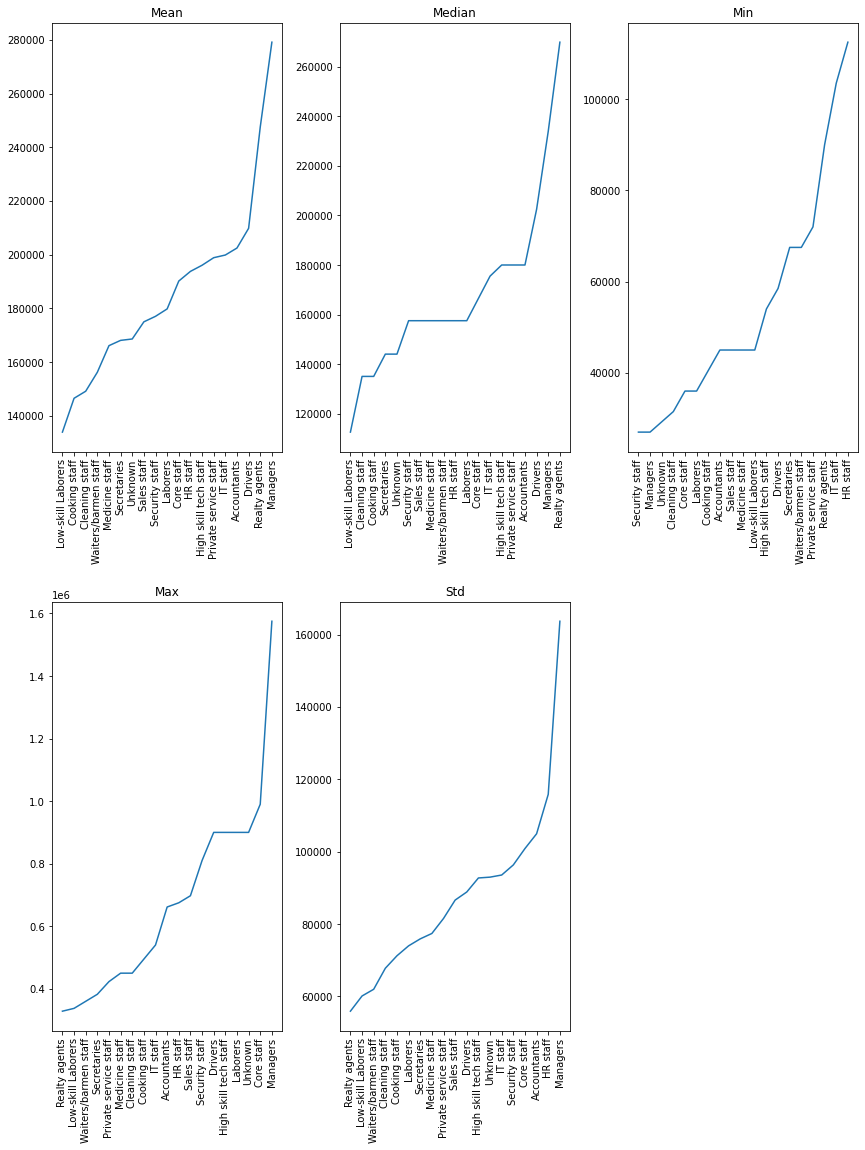

In [94]:
plot_sort(occup_income)

By looking at how the statistical characteristics of the different occupation types are distributed in terms of their corresponding yearly income, the plots above show, that the averaged yearly income for the 'Unknown' occupation type is located in the middle of the distribution and not at an extreme point.

Since the **amount of yearly income** heavily **correlates** with the **occupation type**, we can drop 'OCCUPATION_TYPE' since it would just very unlikely add value to our ML training.

Since most of the potential features we can use for training the classification model contain categorical data, we need to perform some data pre-processing on these columns.

One thing that is done next is to encode the categorical features holding string datatypes into binary values {0,1}.

For example in the case of encoding the 'Gender' column, we do the following:

- **'F'**: 1
- **'M'**: 0

In [95]:
# TRAIN DATA:
# Encode the categorial features 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY':
train_data['CODE_GENDER'] = train_data['CODE_GENDER'].replace({'F':1, 'M':0})
train_data['FLAG_OWN_CAR'] = train_data['FLAG_OWN_CAR'].replace({'Y':1, 'N':0})
train_data['FLAG_OWN_REALTY'] = train_data['FLAG_OWN_REALTY'].replace({'Y':1, 'N':0})

# TEST DATA:
# Encode the categorial features 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY':
test_data['CODE_GENDER'] = test_data['CODE_GENDER'].replace({'F':1, 'M':0})
test_data['FLAG_OWN_CAR'] = test_data['FLAG_OWN_CAR'].replace({'Y':1, 'N':0})
test_data['FLAG_OWN_REALTY'] = test_data['FLAG_OWN_REALTY'].replace({'Y':1, 'N':0})

print(train_data.columns)

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'Bad_Behaviour',
       'Good_Behaviour', 'No_Loan', 'Very_Bad_Behaviour', 'Total_Payments',
       'Status'],
      dtype='object')


After encoding some of the categorical features and dropping the occupation type, we create a method for **one-hot-encoding all the other categorical features**:

In [96]:
# Create a method for one hot encoding the dataframe's columns with non-binary categorical data:
def ohe_one_go (data):

    # Assign known categorical columns to a seperate dataframe:
    cat_data = data[['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']]
    
    # Iterate over categorical columns and perform one-hot-encoding on them:
    for column in cat_data.columns:
        cats_df = cat_data[column].value_counts()
        cats = cats_df.index
        cat_type = CategoricalDtype(categories=cats)
        cat_data[column] = cat_data[column].astype(cat_type)
        cat_data = pd.get_dummies(cat_data, prefix=column, columns=[column], drop_first=True)
    return cat_data   

# Use the one hot enciding method for the training and test data:
train_cat_data = ohe_one_go(train_data)
test_cat_data = ohe_one_go(test_data)

/var/folders/jv/qxmgsbq94mv4gw8gm6s5v8_m0000gn/T/ipykernel_11561/467220971.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_data[column] = cat_data[column].astype(cat_type)


In [97]:
# Create a method for mergeing the hot-encoded categorical data with the initial training dataframe:
def ohe_merge (data1,data2):
    """
    data1 = should be the initial dataframe
    data2 = should be the dataframe from the ohe_one_go formula
    """
    
    data1.drop(['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE'], inplace=True, axis=1)
    train_data_ohe = pd.concat([data1, data2], axis=1)
    return train_data_ohe

# Merge the encoded categorical data and the other dataset together:
train_data_ohe = ohe_merge(train_data, train_cat_data)
test_data_ohe = ohe_merge(test_data, test_cat_data)

By looking at the data of the columns 'DAYS_BIRTH' and 'DAYS_EMPLOYED', we see that these hold negative values. We would like to transform these, so that the **'DAYS_BIRTH'** becomes an **'AGE_YEARS'** feature which shows the age of the applicant in years rather than showing how many days have passed since the applicant was born.



In [98]:
# Create a method for converting 'DAYS_EMPLOYED' into 'YEARS_EMPLOYED'
# and 'DAYS_BIRTH' into 'AGE_YEARS':
def year_conversion (data):

    data['DAYS_BIRTH'] = round(data['DAYS_BIRTH']/-365,0)
    data.rename(columns={'DAYS_BIRTH':'AGE_YEARS'}, inplace=True)
    data['DAYS_EMPLOYED'].replace(365243, -18262.5, inplace=True)
    data['DAYS_EMPLOYED'] = abs(round(data['DAYS_EMPLOYED']/-365,0))
    data.rename(columns={'DAYS_EMPLOYED':'YEARS_EMPLOYED'}, inplace=True) 
    return data

year_conversion(train_data_ohe)
year_conversion(test_data_ohe)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AGE_YEARS,YEARS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,...,NAME_EDUCATION_TYPE_Academic degree,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Co-op apartment
0,6153651,0,1,1,0,270000.0,46.0,2.0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,6153712,1,0,1,1,112500.0,30.0,4.0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,6153733,0,1,1,0,112500.0,56.0,12.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,6153734,0,1,1,0,112500.0,56.0,12.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,6153735,0,1,1,0,112500.0,56.0,12.0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402001,6840104,0,0,1,0,135000.0,62.0,50.0,1,0,...,0,0,0,1,0,0,0,0,0,0
402002,6840222,1,0,0,0,103500.0,44.0,8.0,1,0,...,0,1,0,0,0,0,0,0,0,0
402003,6841878,1,0,0,0,54000.0,22.0,1.0,1,1,...,0,1,0,0,0,1,0,0,0,0
402004,6842765,1,0,1,0,72000.0,59.0,50.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
# Checkpoint: Show current columns of training dataset:
train_data = train_data_ohe
test_data = test_data_ohe

print("Columns of training data:\n", train_data.columns)
print("Shape of the training data = ", train_data.shape)
print("---------------------------------------------------------------------")
print("Columns of test data:\n", test_data.columns)
print("Shape of the test data = ", test_data.shape)

Columns of training data:
 Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AGE_YEARS', 'YEARS_EMPLOYED', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'Bad_Behaviour', 'Good_Behaviour', 'No_Loan',
       'Very_Bad_Behaviour', 'Total_Payments', 'Status',
       'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Academic degree',
       'NAME_FAMILY_STATUS_Single / not married',
       'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_With parents',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_Rented apartment'

Since we are not going to use all columns for the data pipeline and the model training, we define a method for selecting the columns that we would like to use as well as a method for standardizing the data of the input features.

**STANDARDIZATION:**
Standardizing the data is a crucial step in data pre-processing as it is needed for scaling the values of all input features to the same range. This ensures, that single features are not overweighted during the statistical training process in comparison to other features with a smaller range of values.

In [100]:
# Create a method for standardizing the input featrues using mean normalization:
def standardize_columns(data):
    standardized_data = (data-data.mean())/data.std()
    return standardized_data

In [101]:
# Create a method for selecting columns for the model training:
def select_columns(data, *columns):
    return data.reindex(columns = columns)

Now that the training data is cleaned up and mostly prepared, we would like to figure out more about the potential of the features in order to choose, which of these we want to use for the model training.

### 1) Grouped Variance Test:
First thing is to check for **linear relationships between the numerical input features and the 'Status' classes**. To do so, we use a grouped variance test:

- Measuring a numerical variables' overall variance
- Group the variable by the 'Status' variable and measure the grouped variances
- If the grouped variances differ significantly from the overall variance, there is a relationship!

### 2) Chi-Square Test: 
To check the linear relationship of the categorical input features, we perform a **Chi-Square test** on the. Concretely, a Chi-Square test on every single feature is done to test, whether its independent from the 'Status' target feature. This should helps us choosing the **features with signfificance** for predicting the status {0,1} for an applicant. Concretely, we define the following **Null-Hypotheses (H0)** and a **confidence level (alpha)** which determines the decision of rejecting this Null-Hypothesis:

- **H0**: The feature is independent from the target feature 'Status'
- **alpha = 0.05**: If the test gives a p-value smaller or equal to alpha, we reject the Null-Hypothesis and conclude, that the feature is not independent from 'Status'

In [102]:
# Get the numerical features only:
num_train_data = pd.DataFrame(train_data, columns=['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS', 'Total_Payments', 'Status'])

# Calculate the overall variances of the numerical features:
cnt_children_var = num_train_data['CNT_CHILDREN'].var()
total_income_var = num_train_data['AMT_INCOME_TOTAL'].var()
cnt_fam_members_var = num_train_data['CNT_FAM_MEMBERS'].var()
total_payments_var = num_train_data['Total_Payments'].var()

# Print the features' variances:
print("CNT_CHILDREN overall variance = ", cnt_children_var, "\n\n")
print("AMT_INCOME_TOTAL overall variance = ", total_income_var, "\n\n")
print("CNT_FAM_MEMBERS overall variance = ", cnt_fam_members_var, "\n\n")
print("Total_Payments overall variance = ", total_payments_var, "\n\n")

CNT_CHILDREN overall variance =  0.5511086152826647 


AMT_INCOME_TOTAL overall variance =  10361046627.874454 


CNT_FAM_MEMBERS overall variance =  0.8311716246329955 


Total_Payments overall variance =  222.36323455062916 




In [103]:
# Method for grouping a numerical variable into the classes of the 'Status' variable:
def groupby_categorical(data, column):
    vars_grouped = data.groupby(data[column]).var()
    
    return vars_grouped

# Calculate the grouped variances of the numerical variables:
vars_grouped = groupby_categorical(num_train_data, 'Status')
print("Grouped variances of numerical features:\n", vars_grouped)

Grouped variances of numerical features:
         CNT_CHILDREN  AMT_INCOME_TOTAL  CNT_FAM_MEMBERS  Total_Payments
Status                                                                 
0           0.593459      1.078453e+10         0.871790      221.921352
1           0.544264      1.028694e+10         0.824562      222.260679


## Conclusion from the Grouped Variance Test:
After computing the grouped variances of the numerical variables only the variance of "AMT_INCOME_TOTAL" and "CNT_CHILDREN" differ significantly from their overall variances.

Thus, it can be concluded that from all numerical variables, **only "AMT_INCOME_TOTAL" and "CNT_CHILDREN" seem to have a linear relationship with the "Status" variable**. It is of interest to keep them for later training of the classifier.

In [104]:
# CHI-SQUARE HYPOTHESIS TEST:
# Select the categorical data (the nominal features):
nominal_features = select_columns(train_data, 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_MOBIL',
                                                  'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'NAME_INCOME_TYPE_Commercial associate',
                                                  'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant',
                                                  'NAME_INCOME_TYPE_Student', 'NAME_EDUCATION_TYPE_Higher education',
                                                  'NAME_EDUCATION_TYPE_Incomplete higher',
                                                  'NAME_EDUCATION_TYPE_Lower secondary',
                                                  'NAME_EDUCATION_TYPE_Academic degree',
                                                  'NAME_FAMILY_STATUS_Single / not married',
                                                  'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Separated',
                                                  'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_With parents',
                                                  'NAME_HOUSING_TYPE_Municipal apartment',
                                                  'NAME_HOUSING_TYPE_Rented apartment',
                                                  'NAME_HOUSING_TYPE_Office apartment',
                                                  'NAME_HOUSING_TYPE_Co-op apartment', 'Status',)

# Convert into NumPy-Arrays:
chi2_features = np.array(nominal_features)
status = np.array(nominal_features['Status'])

# Perform the chi-square test:
chi2_selector = SelectKBest(chi2, k='all')
chi2 = chi2_selector.fit(chi2_features, status)

# Get the p-values of every feature:
chi2_pvals = chi2.pvalues_  
chi2_pvals = pd.DataFrame(chi2_pvals)
columns = pd.DataFrame(nominal_features.columns)
frames = [columns, chi2_pvals]
chi2_data = pd.concat(frames, axis=1)

# Get the features with a p-value < 0.05:
feature_selection = chi2_data[chi2_data.iloc[:,1] < 0.05]

print("Chi-Square test results (P-values):\n", chi2_data, "\n")
print("Features with significance (p < 0.05): \n", feature_selection)  

Chi-Square test results (P-values):
                                           0         0
0                               CODE_GENDER  0.013492
1                              FLAG_OWN_CAR  0.133295
2                           FLAG_OWN_REALTY  0.183715
3                                FLAG_MOBIL  1.000000
4                           FLAG_WORK_PHONE  0.000563
5                                FLAG_PHONE  0.001696
6                                FLAG_EMAIL  0.949048
7     NAME_INCOME_TYPE_Commercial associate  0.000112
8                NAME_INCOME_TYPE_Pensioner  0.000045
9            NAME_INCOME_TYPE_State servant  0.704605
10                 NAME_INCOME_TYPE_Student  0.183743
11     NAME_EDUCATION_TYPE_Higher education  0.015862
12    NAME_EDUCATION_TYPE_Incomplete higher  0.495295
13      NAME_EDUCATION_TYPE_Lower secondary  0.971954
14      NAME_EDUCATION_TYPE_Academic degree  0.464430
15  NAME_FAMILY_STATUS_Single / not married  0.253884
16        NAME_FAMILY_STATUS_Civil marriage  

As shown above, with a confidence level of **alpha=0.05**, we can **reject** the Null-Hypothesis of independence **for 7 out of 24 nominal features (~29%)**.

Therefore, we drop the features which doesn't seem significant based on the hypothesis test.
Combined with the results of the **Grouped Variance Test** we will keep the following input features in our training data:

### Nominal Features:
- **CODE_GENDER**
- **FLAG_WORK_PHONE**
- **FLAG_PHONE**
- **NAME_INCOME_TYPE_Pensioner**
- **NAME_EDUCATION_TYPE_Higher education**
- **NAME_HOUSING_TYPE_Co-op apartment**

### Numerical Features:
- **AMT_INCOME_TOTAL**
- **CNT_CHILDREN**

In [105]:
# Define names of dataset (train and test) for use of boolean
train_data.name = 'training_data'
test_data.name = 'test_data'

## Data Synthesizing (SMOTE Oversampling):
Data synthesizing with the **SMOTE technique** is used in order to overcome the skewed data classes of good and bad applicants.


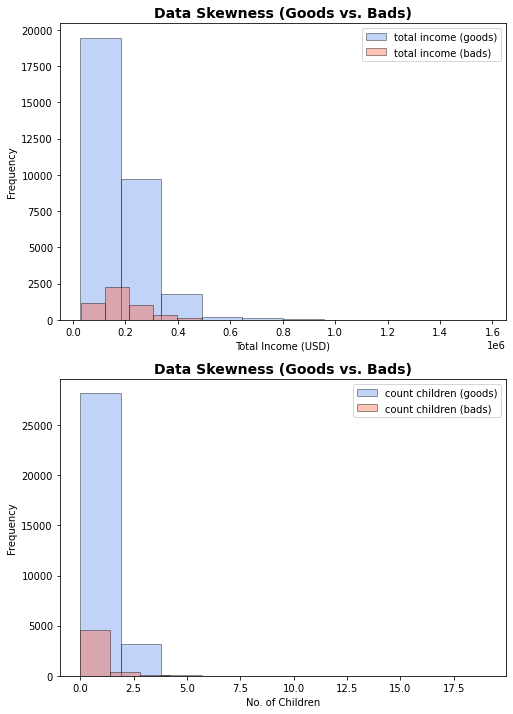

In [106]:
# Split the training_data into entries of good and entries of bad applicants:
num_train_data_goods = num_train_data.where(num_train_data['Status'] == 1)
num_train_data_bads = num_train_data.where(num_train_data['Status'] == 0)


# Visualize the data skewness. Histograms of numerical data grouped by 'good' and 'bad' applicants:
fig, ax = plt.subplots(2, figsize=(8,12))

ax[0].hist(num_train_data_goods['AMT_INCOME_TOTAL'],
                  alpha=0.4, 
                  color='cornflowerblue', 
                  edgecolor='black', 
                  linewidth=1, 
                  label='total income (goods)')
ax[0].hist(num_train_data_bads['AMT_INCOME_TOTAL'], 
                  alpha=0.4, 
                  color='tomato', 
                  edgecolor='black', 
                  linewidth=1, 
                  label='total income (bads)')
ax[0].set_xlabel('Total Income (USD)')
ax[0].set_ylabel('Frequency')
ax[0].legend(loc='upper right')
ax[0].set_title('Data Skewness (Goods vs. Bads)', fontweight='bold', fontsize=14)

ax[1].hist(num_train_data_goods['CNT_CHILDREN'],
                  alpha=0.4, 
                  color='cornflowerblue', 
                  edgecolor='black', 
                  linewidth=1, 
                  label='count children (goods)')
ax[1].hist(num_train_data_bads['CNT_CHILDREN'], 
                  alpha=0.4, 
                  color='tomato', 
                  edgecolor='black', 
                  linewidth=1, 
                  label='count children (bads)')

ax[1].set_xlabel('No. of Children')
ax[1].set_ylabel('Frequency')
ax[1].legend(loc='upper right')
ax[1].set_title('Data Skewness (Goods vs. Bads)', fontweight='bold', fontsize=14)

plt.savefig('data_skewness.png', dpi=300)
plt.show()

Next, a pipeline function for pre-processing the data is defined. Inside the method **preprocess_data()**, **outliers are removed** and the data is splittet into input features **(X)** as well as the target feature **(y)**. Furthermore, the **SMOTE algorithm** is applied to the dataset to balance it out.

In the last step of the method, the training data is divided into **training and crossvalidation data**.

In [107]:
# Check columns of training data/ test data

print("Columns of training data before pipeline:\n", train_data.columns)
print("Shape of training data = ", train_data.shape)
print("---------------------------------------------------------------")
print("Columns of test data before pipeline:\n", test_data.columns)
print("Shape of test data = ", test_data.shape)


Columns of training data before pipeline:
 Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AGE_YEARS', 'YEARS_EMPLOYED', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'Bad_Behaviour', 'Good_Behaviour', 'No_Loan',
       'Very_Bad_Behaviour', 'Total_Payments', 'Status',
       'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_EDUCATION_TYPE_Higher education',
       'NAME_EDUCATION_TYPE_Incomplete higher',
       'NAME_EDUCATION_TYPE_Lower secondary',
       'NAME_EDUCATION_TYPE_Academic degree',
       'NAME_FAMILY_STATUS_Single / not married',
       'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Separated',
       'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_With parents',
       'NAME_HOUSING_TYPE_Municipal apartment',
       'NAME_HOUSING_TYPE_R

In [108]:
# Create a method as data pipeline:
def preprocess_data(data):

    if data.name == 'training_data':
        data = index_reset(data)
        
        # Select the columns we want to use for the model training:
        data = select_columns(data, 'CODE_GENDER', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
                                    'NAME_INCOME_TYPE_Pensioner', 'NAME_EDUCATION_TYPE_Higher education',
                                    'NAME_HOUSING_TYPE_Co-op apartment', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN',
                                    'CNT_FAM_MEMBERS', 'NAME_FAMILY_STATUS_Single / not married', 'No_Loan', 'Status')
        
        # Define the input features:
        X = data.drop('Status', axis=1)
        
        # Define the columns we need to normalize:
        cols_to_standardize = standardize_columns(X[['AMT_INCOME_TOTAL', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS']])

        # Normalize the continuous variables:
        X['AMT_INCOME_TOTAL'] = cols_to_standardize['AMT_INCOME_TOTAL']
        X['CNT_CHILDREN'] = cols_to_standardize['CNT_CHILDREN']
        X['CNT_FAM_MEMBERS'] = cols_to_standardize['CNT_FAM_MEMBERS']
        
        # Define the Target feature (label to predict):
        y = data['Status']
        
        print("X data shape before SMOTE: ", X.shape)
        print("y data shape before SMOTE: ", y.shape)
        
        # Synthesize data of minority class and balance the dataset
        # -> SMOTE (Synthetic Minority Oversampling Technique):
        X, y = SMOTE().fit_resample(X,y)
        
        print("X data shape after SMOTE: ", X.shape)
        print("y data shape after SMOTE: ", y.shape)

        return X, y

    elif data.name == "test_data":

        print("Shape of test data: ", data.shape)
        
        # Select the columns for testing (train data without 'Status' labels):
        data = select_columns(data, 'CODE_GENDER', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
                                    'NAME_INCOME_TYPE_Pensioner', 'NAME_EDUCATION_TYPE_Higher education',
                                    'NAME_HOUSING_TYPE_Co-op apartment', 'AMT_INCOME_TOTAL', 'CNT_CHILDREN',
                                    'CNT_FAM_MEMBERS', 'NAME_FAMILY_STATUS_Single / not married', 'No_Loan')
    
        # Define the input features:
        X = data
        
        # Normalize the columns with numerical data:
        cols_to_standardize = standardize_columns(X[['AMT_INCOME_TOTAL', 'CNT_CHILDREN']])
        X['AMT_INCOME_TOTAL'] = cols_to_standardize['AMT_INCOME_TOTAL']
        X['CNT_CHILDREN'] = cols_to_standardize['CNT_CHILDREN']
        X['CNT_FAM_MEMBERS'] = cols_to_standardize['CNT_FAM_MEMBERS']

        X_test = X

        return X_test
    
X_train, y_train = preprocess_data(train_data)
#X_test = preprocess_data(test_data)
#print("Test data: ", X_test.shape)
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)

X data shape before SMOTE:  (36457, 11)
y data shape before SMOTE:  (36457,)
X data shape after SMOTE:  (62822, 11)
y data shape after SMOTE:  (62822,)
X_train:  (62822, 11)
y_train:  (62822,)


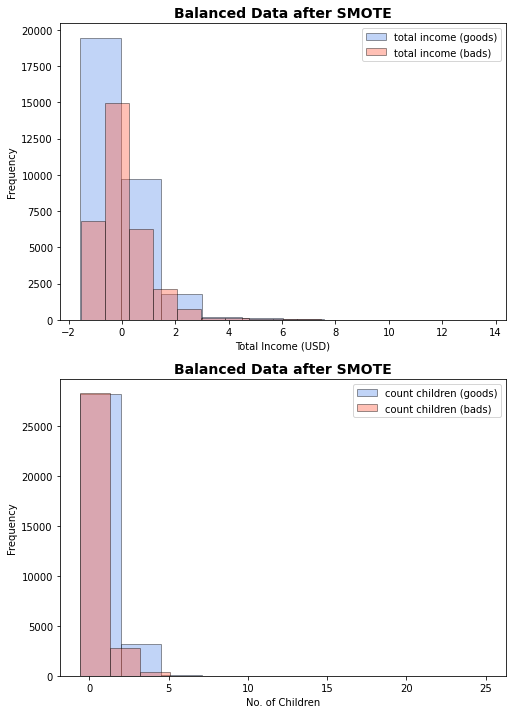

In [109]:
# Merge balanced 'X_train' and 'y_train' to one balanced pandas DataFrame:
train_data_balanced = pd.concat([X_train, y_train], axis=1)
train_data_balanced.head(10)

# Split the balanced dataset into subsets of 'good' and 'bad' applicants entries:
data_balanced_goods = train_data_balanced.where(train_data_balanced['Status'] == 1)
data_balanced_bads = train_data_balanced.where(train_data_balanced['Status'] == 0)


# # Visualize the training data after balancing the data with SMOTE:
fig, ax = plt.subplots(2, figsize=(8,12))

ax[0].hist(data_balanced_goods['AMT_INCOME_TOTAL'],
                  alpha=0.4, 
                  color='cornflowerblue', 
                  edgecolor='black', 
                  linewidth=1, 
                  label='total income (goods)')
ax[0].hist(data_balanced_bads['AMT_INCOME_TOTAL'], 
                  alpha=0.4, 
                  color='tomato', 
                  edgecolor='black', 
                  linewidth=1, 
                  label='total income (bads)')
ax[0].set_xlabel('Total Income (USD)')
ax[0].set_ylabel('Frequency')
ax[0].legend(loc='upper right')
ax[0].set_title('Balanced Data after SMOTE', fontweight='bold', fontsize=14)

ax[1].hist(data_balanced_goods['CNT_CHILDREN'],
                  alpha=0.4, 
                  color='cornflowerblue', 
                  edgecolor='black', 
                  linewidth=1, 
                  label='count children (goods)')
ax[1].hist(data_balanced_bads['CNT_CHILDREN'], 
                  alpha=0.4, 
                  color='tomato', 
                  edgecolor='black', 
                  linewidth=1, 
                  label='count children (bads)')

ax[1].set_xlabel('No. of Children')
ax[1].set_ylabel('Frequency')
ax[1].legend(loc='upper right')
ax[1].set_title('Balanced Data after SMOTE', fontweight='bold', fontsize=14)

plt.savefig('smote.png', dpi=300)
plt.show()

### Conclusion Data Oversampling (SMOTE):
After looking at the distributions of the 'good applicant' and the 'bad applicant' entries it was easy to see that the **dataset was significantly skewed**. This means that we've had a lot more datapoints representing the good applicants than data for bad applicants. Training a **binary classifier (ML model) requires a balanced dataset** in order to yield a model which is capable of properly detecting both classes.

Therefore, the **SMOTE algorithm** was used **to synthesize data by oversampling the minority class** (bad applicants data) based on the feature space of the dataset. As the plottet distributions above (histograms) show, the data is way more balanced now and can be used for training.

## Model Training and Evaluation

Several model types based on different algorithm will be train to yield the Credit Card Scoring Classifier:

- **Logistic Regression**
- **Random Forest Classifier**
- **Support Vector Machine (Radial Basis Kernel)**

For each of the model evaluation processes, **K-Fold cross-validation with k=10** will be used to determine the averaged metrics to determine the performanvce of every single model type. The Metrics we will look at are:

- **Accuracy:** What percentage is classified correctly by the model?
- **Precision:** What fraction of the applicants classified as bad applicants are really bad applicants?
- **Recall:** What fraction of the bad applicants have been detected as bad applicants by the model?
- **F1-Score**

In [110]:
# Create a method for K-Fold Crossvalidation:
def cross_validation(model, X, y, cv=5):
    
    # Define the metrics:
    scores = ['accuracy', 'precision', 'recall', 'f1']
    
    # Get the CV results:
    results = cross_validate(estimator=model, X=X, y=y, cv=cv, scoring=scores, return_train_score=True)
    
    # Return the training and validation metrics:
    return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [111]:
# Create a method for visualizing the results for each model type:
def plot_cv_results(a_label, metric_1, metric_2, metric_3, metric_4, main_title,
                    plot_title_1, plot_title_2, plot_title_3, plot_title_4,
                    train_data_1, val_data_1, train_data_2, val_data_2,
                    train_data_3, val_data_3, train_data_4, val_data_4):
    
    '''
    a_label = Name (str) of algorithm
    metric_1 = Accuracy
    metric_2 = F1-Score
    train_data_1 = Accuracy score on training data
    val_data_1 = Accuracy score on validation data
    train_data_2 = F1-Score on training data
    val_data_2 = F1-Score on validation data
    
    '''
    # Initialize the figure:
    plt.figure(figsize=(12,6))
   
    # Set the labels for each Fold:
    labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold"]
              #"6th Fold", "7th Fold", "8th Fold", "9th FOld", "10th Fold"]
    
    x_axis = np.arange(len(labels))
    
    fig, ax = plt.subplots(2,2, figsize=(15,10))
    
    # Subplot - Accuracy: 
    ax[0,0].bar(x_axis-0.2, train_data_1, 0.4, color='cornflowerblue',linewidth=1, edgecolor='black', label='Training')
    ax[0,0].bar(x_axis+0.2, val_data_1, 0.4, color='lightsalmon', linewidth=1, edgecolor='black', label='Validation')
    ax[0,0].set_title(plot_title_1, fontweight='bold', fontsize=14)
    ax[0,0].set_xticks(x_axis, labels)
    ax[0,0].set_xlabel('Fold K', fontsize=14)
    ax[0,0].set_ylabel(metric_1, fontsize=14)
    ax[0,0].legend()
    
    # Subplot - F1-Score: 
    ax[0,1].bar(x_axis-0.2, train_data_2, 0.4, color='cornflowerblue',linewidth=1, edgecolor='black', label='Training')
    ax[0,1].bar(x_axis+0.2, val_data_2, 0.4, color='lightsalmon', linewidth=1, edgecolor='black', label='Validation')
    ax[0,1].set_title(plot_title_2, fontweight='bold', fontsize=14)
    ax[0,1].set_xticks(x_axis, labels)
    ax[0,1].set_xlabel('Fold K', fontsize=14)
    ax[0,1].set_ylabel(metric_2, fontsize=14)
    ax[0,1].legend()
    
    # Subplot - Precision:
    ax[1,0].bar(x_axis-0.2, train_data_3, 0.4, color='cornflowerblue',linewidth=1, edgecolor='black', label='Training')
    ax[1,0].bar(x_axis+0.2, val_data_3, 0.4, color='lightsalmon', linewidth=1, edgecolor='black', label='Validation')
    ax[1,0].set_title(plot_title_3, fontweight='bold', fontsize=14)
    ax[1,0].set_xticks(x_axis, labels)
    ax[1,0].set_xlabel('Fold K', fontsize=14)
    ax[1,0].set_ylabel(metric_3, fontsize=14)
    ax[1,0].legend()
    
    # Subplot - Recall:
    ax[1,1].bar(x_axis-0.2, train_data_4, 0.4, color='cornflowerblue',linewidth=1, edgecolor='black', label='Training')
    ax[1,1].bar(x_axis+0.2, val_data_4, 0.4, color='lightsalmon', linewidth=1, edgecolor='black', label='Validation')
    ax[1,1].set_title(plot_title_4, fontweight='bold', fontsize=14)
    ax[1,1].set_xticks(x_axis, labels)
    ax[1,1].set_xlabel('Fold K', fontsize=14)
    ax[1,1].set_ylabel(metric_4, fontsize=14)
    ax[1,1].legend()
    
    # Subplots adjustments:
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.suptitle(main_title, fontsize=18, fontweight='bold')
    plt.savefig('results.png', dpi=300)
    plt.show()

In [112]:
# Specify the models to train and evaluate:
lr_model = LogisticRegression()
rfc_model = RandomForestClassifier()
svm_model = SVC(gamma=2, C=1)

Now that the cross-validation method as well as the model algorithms we want to use are specified, we evaluate one after the other model types by using the **cross_validation()** and **plot_cv()** methods.

## A) Logistic Regression Evaluation

In [113]:
# Evaluation of the Logistic Regression model:
lr_results = cross_validation(lr_model, X_train, y_train, 5)
print(lr_results)


{'Training Accuracy scores': array([0.79393915, 0.79234733, 0.7935652 , 0.79440089, 0.79334633]), 'Mean Training Accuracy': 79.35197830653327, 'Training Precision scores': array([0.7406804 , 0.73946348, 0.7392644 , 0.74055407, 0.73973137]), 'Mean Training Precision': 0.739938744231768, 'Training Recall scores': array([0.90456861, 0.90278165, 0.90703968, 0.90632337, 0.90516933]), 'Mean Training Recall': 0.9051765256763795, 'Training F1 scores': array([0.8144618 , 0.81300172, 0.81460303, 0.81509583, 0.81413078]), 'Mean Training F1 Score': 0.8142586320978811, 'Validation Accuracy scores': array([0.79411062, 0.79665738, 0.79401465, 0.78892073, 0.79091054]), 'Mean Validation Accuracy': 79.29227830626175, 'Validation Precision scores': array([0.73869801, 0.73918624, 0.74457097, 0.73737902, 0.73736849]), 'Mean Validation Precision': 0.7394405474170076, 'Validation Recall scores': array([0.91023396, 0.91674626, 0.8950971 , 0.89748488, 0.90369309]), 'Mean Validation Recall': 0.904651059090587, 

/var/folders/jv/qxmgsbq94mv4gw8gm6s5v8_m0000gn/T/ipykernel_11561/1780332251.py:32: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0,0].set_xticks(x_axis, labels)
/var/folders/jv/qxmgsbq94mv4gw8gm6s5v8_m0000gn/T/ipykernel_11561/1780332251.py:41: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0,1].set_xticks(x_axis, labels)
/var/folders/jv/qxmgsbq94mv4gw8gm6s5v8_m0000gn/T/ipykernel_11561/1780332251.py:50: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1,0].set_xticks(x_axis, labels)
/var/folders/jv/qxmgsbq94mv4gw8gm6s5v8_m0000gn/T/ipykernel_11561/1780332251.py:

<Figure size 864x432 with 0 Axes>

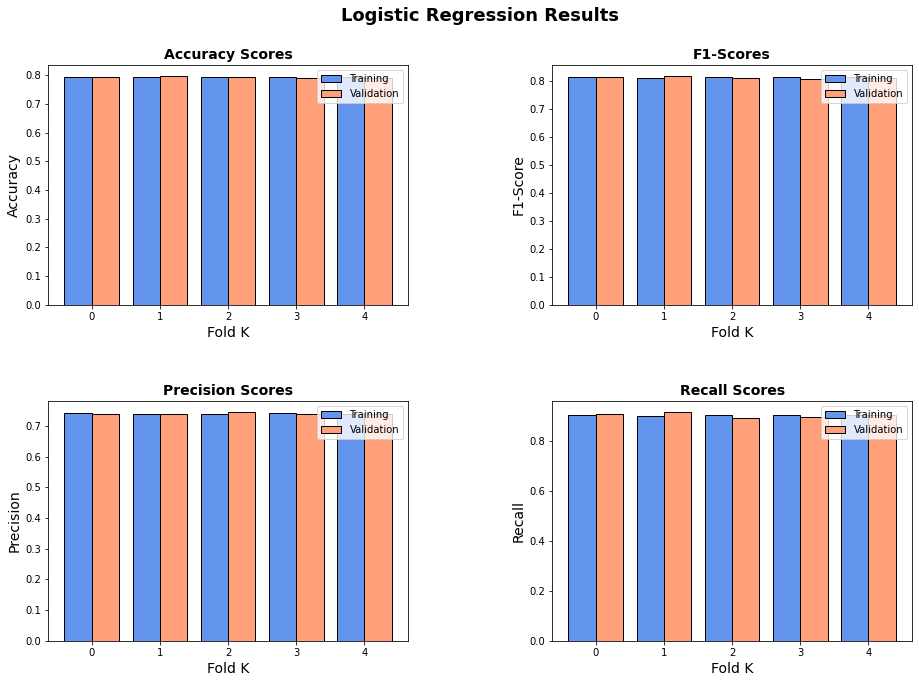

In [114]:
# Plot the Logistic Regression results:
model_name = 'Logistic Regressor'

plot_cv_results('Logistic Regressor', 'Accuracy', 'F1-Score', 'Precision', 'Recall',
                'Logistic Regression Results', 'Accuracy Scores', 'F1-Scores',
                'Precision Scores', 'Recall Scores',
                lr_results['Training Accuracy scores'], lr_results['Validation Accuracy scores'], 
                lr_results['Training F1 scores'], lr_results['Validation F1 scores'],
                lr_results['Training Precision scores'], lr_results['Validation Precision scores'], 
                lr_results['Training Recall scores'], lr_results['Validation Recall scores'])

## B) Random Forest Classifier Evaluation

In [115]:
# Evaluation of the Random Forest Classifier:
rfc_results = cross_validation(rfc_model, X_train, y_train, 5)
print(rfc_results)


{'Training Accuracy scores': array([0.96979525, 0.95678214, 0.95743961, 0.95690238, 0.95630546]), 'Mean Training Accuracy': 95.94449702630116, 'Training Precision scores': array([0.9583398 , 0.9445757 , 0.94191143, 0.94110415, 0.94222685]), 'Mean Training Precision': 0.9456315866368312, 'Training Recall scores': array([0.98229067, 0.97051216, 0.97500895, 0.97480998, 0.97222333]), 'Mean Training Recall': 0.974969018191506, 'Training F1 scores': array([0.97016744, 0.9573683 , 0.95817446, 0.95766058, 0.95699009]), 'Mean Training F1 Score': 0.9600721732500395, 'Validation Accuracy scores': array([0.82021488, 0.86534023, 0.860156  , 0.85928048, 0.86787647]), 'Mean Validation Accuracy': 85.45736142134129, 'Validation Precision scores': array([0.80237451, 0.89110429, 0.89028808, 0.88332201, 0.89156218]), 'Mean Validation Precision': 0.8717302158545124, 'Validation Recall scores': array([0.8497533 , 0.83237822, 0.82155365, 0.82792104, 0.83763133]), 'Mean Validation Recall': 0.8338475086500299,

/var/folders/jv/qxmgsbq94mv4gw8gm6s5v8_m0000gn/T/ipykernel_11561/1780332251.py:32: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0,0].set_xticks(x_axis, labels)
/var/folders/jv/qxmgsbq94mv4gw8gm6s5v8_m0000gn/T/ipykernel_11561/1780332251.py:41: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0,1].set_xticks(x_axis, labels)
/var/folders/jv/qxmgsbq94mv4gw8gm6s5v8_m0000gn/T/ipykernel_11561/1780332251.py:50: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1,0].set_xticks(x_axis, labels)
/var/folders/jv/qxmgsbq94mv4gw8gm6s5v8_m0000gn/T/ipykernel_11561/1780332251.py:

<Figure size 864x432 with 0 Axes>

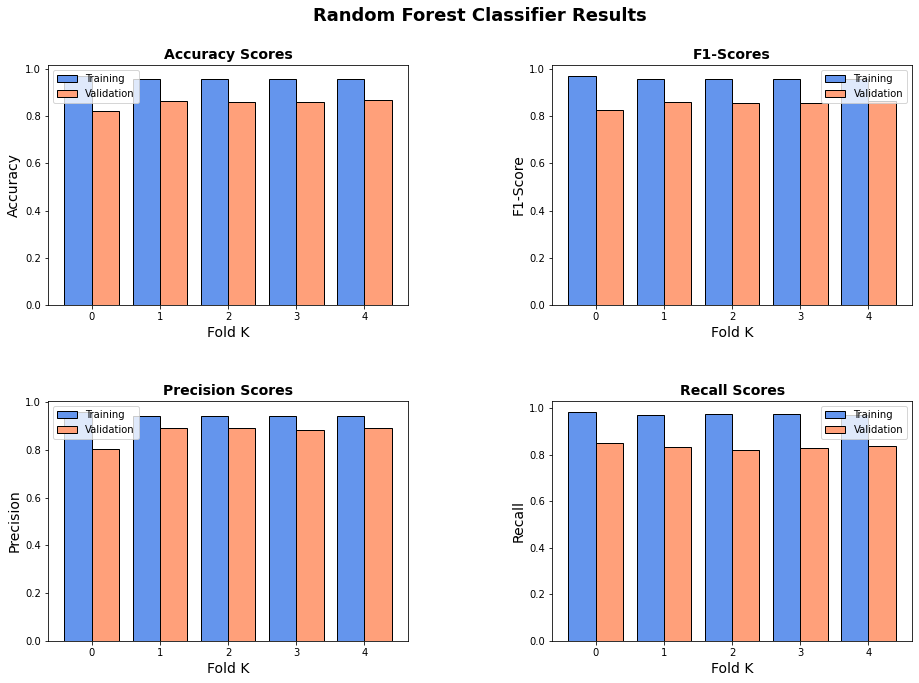

In [116]:
# Plot the Random Forest results:
model_name = 'Random Forest Classifier'

plot_cv_results('Random Forest', 'Accuracy', 'F1-Score', 'Precision', 'Recall',
                'Random Forest Classifier Results', 'Accuracy Scores', 'F1-Scores',
                'Precision Scores', 'Recall Scores',
                rfc_results['Training Accuracy scores'], rfc_results['Validation Accuracy scores'], 
                rfc_results['Training F1 scores'], rfc_results['Validation F1 scores'],
                rfc_results['Training Precision scores'], rfc_results['Validation Precision scores'], 
                rfc_results['Training Recall scores'], rfc_results['Validation Recall scores'])

## C) Support Vector Machine Evaluation

In [ ]:
# Evaluation of the Support Vector Machine:
svm_results = cross_validation(svm_model, X_train, y_train, 5)
print(svm_results)

In [ ]:
# Plot the Support Vector Machine results:
model_name = 'Support Vector Machine'

plot_cv_results('SVM', 'Accuracy', 'F1-Score', 'Precision', 'Recall',
                'Support Vector Machine Results', 'Accuracy Scores', 'F1-Scores',
                'Precision Scores', 'Recall Scores',
                svm_results['Training Accuracy scores'], svm_results['Validation Accuracy scores'], 
                svm_results['Training F1 scores'], svm_results['Validation F1 scores'],
                svm_results['Training Precision scores'], svm_results['Validation Precision scores'], 
                svm_results['Training Recall scores'], svm_results['Validation Recall scores'])

After analyzing the cross-validation scores of three trained classifiers, it can be seen that the **Random Forest classifier slightly outperforms** the Logistic Regression model as well as the Support Vector Machine in terms of **accuracy and precision**.

From an application point of view, **this would have the consequence** that the model based on Random Forest would produce **less false positives** than the other models, giving the highest probability that applicants classified as 'bad' applicants really are to be considered as those.

### ROC Curve:
In the last step of the model evaluation, the training data is split into a **80% training** and **20% testing** set to finally evaluate the Random Forest classifier.
Therefore, after fitting the model, we make some predictions on the test set and visualize the **confusion matrix** as well as the ROC curve which shows us the trade-off between sensitivity (TPR) and specificity (1-FPR).

In [ ]:
# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Fit the Random Forest Classifier:
rfc_model.fit(X_train, y_train)

# Predict on test set:
y_pred = rfc_model.predict(X_test)

In [ ]:
# Compute the confusion matrix:
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix:
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix Random Forest Classifier\n', fontweight='bold', fontsize=14);
ax.set_xlabel('\nPredicted Values', fontweight='bold')
ax.set_ylabel('Actual Values ', fontweight='bold');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Negative','Positive'])
ax.yaxis.set_ticklabels(['Negative','Positive'])

## Display the visualization of the Confusion Matrix.
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [ ]:
# Method for plotting the ROC curve:
#def plot_ROC_curve():
    
#ROC-AUC Curve
pred_proba = rfc_model.predict_proba(X_test)
pred_proba = pred_proba[:,1]
fpr, tpr, thresh = metrics.roc_curve(y_test, pred_proba)

auc = metrics.auc(fpr, tpr)

print("Final chosen model: Random Forest Classifier")
print("Area under the ROC curve: ", auc)

fig = plt.figure(figsize=(8,8))

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)' %auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC Curve Random Forest Classifier', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.grid()
plt.legend()
plt.savefig("roc_auc.png", dpi=300)
plt.show()   

## Conclusion:

By looking at the **AUC score of 0.95** as well as the ROC curve, it can be seen, that the classifier model based on Random Forest is pretty good in **seperating 'good' from 'bad' credit card applicants**, given a test set based **probability of 95%** for predicting the classes correctly. 